In [1]:
from jax.config import config
# config.update("jax_enable_x64", True)

import jax.numpy as np
import numpy.random as npr

from jax import jacfwd, grad, jit, partial
from jax.lax import scan
from jax.ops import index, index_add, index_update
from scipy.linalg import logm
import scipy.linalg

In [16]:
state_dim = 4
action_dim = 1
num_x_obs = 7
num_u_obs = 2
num_obs = num_x_obs + num_u_obs

@jit
def f(s, a):
    th, x, thdot, xdot = s
    sdot = np.array([
                thdot, xdot, 
                9.81*np.sin(th)/1.0+a[0]*np.cos(th)/1.0-0.2*thdot,
                a[0]])
    return s + sdot/60.
@jit
def z(s):
    th, x, thdot, xdot = s
    return np.array([th, x, thdot, xdot, np.sin(th), np.cos(thdot), 1.0])
@jit
def v(z, u):
    th, x, thdot, xdot = z[:state_dim]
    return np.array([u[0] * np.cos(th), u[0]])


Provided a data set $\mathcal{D} = \{(x(t_m), u(t_m), x(t_{m+1}), u(t_{m+1})) \}_{m=0}^{M-1}$, we can compute the approximate Koopman operator $\mathfrak{K}$ using least-squares minimization over the matrix $\mathfrak{K}$:
$$
    \min_{\mathfrak{K}} \frac{1}{2 M} \sum_{m=0}^{M-1} \Vert z(x(t_{m+1}), u(t_{m+1})) - \mathfrak{K} z(x(t_m), u(t_m)) \Vert^2.
$$
Since this optimization is convex in $\mathfrak{K}$, the solution is given by
$$
    \mathfrak{K} = A G^\dagger
$$        
where $\dagger$ denotes the Moore-Penrose pseudoinverse and
$$
A = \frac{1}{M} \sum_{m=0}^{M-1} z(x(t_{m+1}), u(t_{m+1})) z(x(t_m), u(t_m))^\top, \\
            G = \frac{1}{M} \sum_{m=0}^{M-1} z(x(t_m), u(t_m)) z(x(t_m), u(t_m))^\top .
$$
The continuous time operator is then given by $\log(\mathfrak{K})/t_s$.
Note that we can solve the optimization using gradient descent methods or other
optimization methods.

In the next cell, we will collect some data and learn a Koopman operator for the functions of state described previously.

In [18]:
def wrap2Pi(th):
    th = np.fmod(th+np.pi, 2.0 * np.pi)
    if th < 0:
        th = th + 2.0 * np.pi
    return th - np.pi

def ell(z):
    th, x, thdot, xdot = z[:state_dim]
    return -80.*np.cos(th) + 0.1 * (x**4) + 0.1*(np.square(thdot) + np.square(xdot)) 



### Collect data for learning linear embedded model

In [4]:
npr.seed(0) ## set the seed for reproducibility 
num_trials = 600 ## number of resets
horizon    = 10 ## how long we simulate the system for
M = num_trials * horizon ## M sized data

_A = np.zeros((num_obs, num_obs))
_G = np.zeros((num_obs, num_obs))

s_bnds = np.array([6.24, 2.0, 6.0, 1.0])
a_bnds = np.array([6.8])
## loop to collect data
for k in range(num_trials):
#     x_t = npr.uniform(low=-s_bnds, high=s_bnds)
    x_t = npr.normal(s_bnds*0., s_bnds)
    for t in range(horizon):
        u_t = npr.normal(0.*a_bnds, a_bnds)
        x_tpo = f(x_t, u_t)
        u_tpo = u_t

        z1 = np.concatenate([z(x_t), v(x_t, u_t)])
        z2 = np.concatenate([z(x_tpo), v(x_tpo, u_t)])
        _A += np.outer(z2, z1)
        _G += np.outer(z1, z1)
        
        # reset for next loop
        x_t = x_tpo
        u_t = u_tpo



        
_A /= M
_G /= M

koopman_operator = np.dot(_A, np.linalg.pinv(_G))

/home/burn/.local/lib/python3.6/site-packages/jax/lib/xla_bridge.py:122: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Extract out the A and B matrices

In [5]:
A = koopman_operator[:num_x_obs,:num_x_obs]
B = koopman_operator[:num_x_obs, num_x_obs:]

In [6]:
class Planner(object):
    
    def __init__(self,T):
        self.T = T
        self.dldz = jit(grad(ell))
        self.dvdu = jit(jacfwd(v, argnums=1))
        self.u = [np.zeros(action_dim) for t in range(self.T-1)]
    def update(self, z0):
        zt = z0
        z = []
        for t in range(self.T-1):
            z.append(zt)
            zt = np.dot(A, zt) + np.dot(B, v(zt, self.u[t]))
        rho = np.zeros_like(zt)
        for t in reversed(range(self.T-1)):
            rho = self.dldz(z[t]) + np.dot(A.T, rho)
            Beff = np.dot(B, self.dvdu(z[t], self.u[t]))
            self.u[t] = np.clip(- np.dot(Beff.T, rho), -4.8, 4.8)
        u_out = self.u[0]
        self.u[0:-1] = self.u[1:]
        self.u[-1] = np.zeros_like(self.u[-1])
        return u_out
planner = Planner(int(1.*60))
            

In [20]:
def sim_step(zt, i, K, A, B):
    u = np.dot(K, zt)
    zn = np.dot(A, zt) + np.dot(B, v(zt, u))
    return zn, ell(zn) + 1e-3*np.dot(u, u)
# control objective
def J(x0, K, A, B, T):   
    zf, lt = scan(partial(sim_step, A=A, B=B, K=K), z(x0), None, length=T)
    return np.sum(lt) + ell(zf)
# contro updater
dJ = jit(grad(J, argnums=1), static_argnums=4)
def replan(x0, K, A, B, T):
    dK = dJ(x0, K, A, B, T)
    return K - .001* dK

Here we calculate the continuous time Koopman operator.

For optimal control with the Koopman operator, we split $\mathfrak{K}$ into the free dynamics $A$ and dynamic actuation matrix $B$. 

Since the Koopman operator representation of the dynamical system is linear, we can directly apply LQR control.

In [21]:
np.abs(A)

DeviceArray([[1.000001, 0.      , 0.016667, 0.      , 0.      , 0.      ,
              0.      ],
             [0.      , 1.      , 0.      , 0.016665, 0.      , 0.      ,
              0.      ],
             [0.      , 0.      , 0.996666, 0.      , 0.163504, 0.      ,
              0.      ],
             [0.      , 0.      , 0.      , 1.      , 0.      , 0.      ,
              0.      ],
             [0.      , 0.00171 , 0.001295, 0.001095, 0.996943, 0.005499,
              0.002179],
             [0.      , 0.      , 0.      , 0.      , 0.008947, 0.990818,
              0.001168],
             [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
              1.      ]], dtype=float32)

In [9]:
np.set_printoptions(precision=6, suppress=True)

Note that the augmented state observables show up in the linear dynamics embedding as part of the update equation $z_{t+1} = Az_t + Bv_t$

In [22]:
B

DeviceArray([[ 0.      ,  0.      ],
             [ 0.      ,  0.      ],
             [ 0.016667,  0.      ],
             [ 0.      ,  0.016667],
             [ 0.      ,  0.      ],
             [-0.001354,  0.      ],
             [ 0.      ,  0.      ]], dtype=float32)

In [11]:
A = index_update(A, np.abs(A)<1e-3, 0.)

In [12]:
B = index_update(B, np.abs(B)<1e-3, 0.)

The controller can then be tested on the true actuated dynamical system.

In [23]:
x_t = np.array([3.4, 0., 0., 0.])
horizon = int(1.5 * 60) # simulation time
K = np.zeros((1, num_x_obs))
trajectory = []

for t in range(int(10*60)):
    for _ in range(1):
        K = replan(x_t, K, A, B, horizon)
    u = np.clip(np.dot(K, z(x_t)), -4.8, 4.8)
#     u = planner.update(z(x_t))
    x_tpo = f(x_t,u)
    
    x_t = x_tpo
    x_t = index_update(x_t, index[0], wrap2Pi(x_t[0]))
    trajectory.append(x_t)
    if t %  20 == 0:
        print(x_t)

[-2.883186  0.       -0.119125  0.08    ]
[ 3.027926  0.271353 -1.567598  1.193495]
[ 2.875401  0.415851  0.8274   -0.406505]
[-2.900719  0.101683  1.180313 -0.726505]
[-2.908857  0.112848 -1.332163  0.873495]
[ 2.811176  0.510679 -0.92862   0.713495]
[ 2.924721  0.495178  1.670138 -0.886505]
[-2.766197  0.154343  0.80169  -0.406505]
[-2.932232  0.272174 -1.838214  1.193495]
[ 2.755091  0.671378 -0.738774  0.531806]
[ 2.94308   0.595313  1.897512 -1.068194]
[-2.724758  0.228582  0.752484 -0.428194]
[-2.919284  0.339184 -1.952761  1.171806]
[ 2.755641  0.702489 -0.760168  0.404105]
[ 2.937301  0.583857  1.88416  -1.195895]
[-2.73173   0.174559  0.759223 -0.555895]
[-2.92194   0.242594 -1.934527  1.044105]
[ 2.739576  0.58585  -0.797105  0.357163]
[ 2.916198  0.451571  1.896448 -1.242837]
[-2.707894 -0.008041  0.944332 -0.762837]
[-2.852601 -0.008987 -1.873568  0.837163]
[ 2.76097   0.303099 -1.062065  0.316937]
[ 2.853922  0.155412  1.697863 -1.283063]
[-2.740553 -0.378943  1.256129 -1.

Here we visualize the resulting trajectory from applying a model-based controller using the Koopman operator representation of the dynamical system.

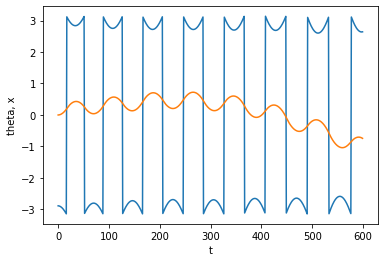

In [24]:
import matplotlib.pyplot as plt
trajectory = np.stack(trajectory)
plt.plot(trajectory[:,0])
plt.plot(trajectory[:,1])
plt.xlabel('t')
plt.ylabel('theta, x')
plt.show()